**Template from:** https://towardsdatascience.com/7-steps-to-a-successful-data-science-project-b452a9b57149

# **1. Definição do Problema**

Your objective as a consultant is to decrease the maintenance costs of this particular (air) system. Maintenance costs for the air system may vary depending on the actual condition of the truck.

- If a truck is sent for maintenance, but it does not show any defect in this system, around $10 will be charged for the time spent during the
inspection by the specialized team. 
- If a truck is sent for maintenance and it is defective in this system, $25 will be charged to perform the preventive repair service.
- If a truck with defects in the air system is not sent directly for maintenance, the company pays $500 to carry out corrective
maintenance of the same, considering the labor, replacement of parts and other possible inconveniences (truck broke down in the middle of
the track for example).

During the alignment meeting with those responsible for the project and the company's IT team, some information was given to you:
- The technical team informed you that all information regarding the air system of the paths will be made available to you, but for bureaucratic reasons regarding company contracts, all columns had to be encoded.
- The technical team also informed you that given the company's recent digitization, some information may be missing from the database sent to
you.

Finally, the technical team informed you that the source of information comes from the company's maintenance sector, where they created a column in the database called **class: "pos"** would be those trucks that had defects in the air system and **"neg"** would be those trucks that had a defect in any system other than the air system.


Those responsible for the project are very excited about the initiative and, when asking for a technical proof of concept, they have put forth as **main requirements:**
- Can we reduce our expenses with this type of maintenance using AI
techniques?
- Can you present to me the main factors that point to a possible failure in
this system?

# 2. **Obtendo os dados**

## 2.1. Bibliotecas

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

## 2.2. Funções

In [123]:
# violin plot para comparar features x target

def violin(df,features,row,col, file_name:str):
  k=0
  fig,axes = plt.subplots(row,col,figsize=(30,10))
  for i in range(len(axes)):
    for j in range(len(axes[0])):
      
      # plotando
      sns.violinplot(x=df['class'],y=features[k], ax= axes[i][j], data=df, hue=df['class'])#,size=5)
      if k!= len(features)-1:
        k+=1
      else:
        break
  plt.show()
  plt.savefig(f'img/{file_name}.png')
  plt.close()

# ---------------------------------------

# Função para plotar um heatmap da confusion matrix
def cm_heatmap(cm):
  A =(((cm.T)/(cm.sum(axis=1))).T)
  B =(cm/cm.sum(axis=0))
  labels = [0,1]
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1);
  sns.heatmap(cm, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);

  # labels, title and ticks
  plt.xlabel('Valores Previstos');
  plt.ylabel('Valores Reais'); 
  plt.title('Confusion Matrix');
 
  plt.subplot(1,3,2)
  sns.heatmap(B, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Valores Previstos');
  plt.ylabel('Valores Reais'); 
  plt.title('Precision Matrix');
  

  ax = plt.subplot(1,3,3)
  sns.heatmap(A, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Valores Previstos');
  plt.ylabel('Valores Reais'); 
  plt.title('Recall Matrix');
  
  plt.show()
  plt.savefig('img/heatmaps_confusion_recall_precision.png')
  plt.close()

# ---------------------------------------
# plota o scatterplot do cross validation
def cv_plot(results,alpha):
  train_score = results['mean_train_score']
  cv_score = results['mean_test_score']

  plt.plot(alpha, train_score, label='f1-macro - Treino')
  plt.plot(alpha, cv_score, label='f1-macro - CV')

  plt.scatter(alpha, train_score, label='f1-macro - Treino')
  plt.scatter(alpha, cv_score, label='f1-macro - CV')

  plt.legend()
  plt.xlabel("alpha: hyperparameter")
  plt.ylabel("f1-macro")
  plt.title("ERROR PLOTS")
  plt.grid()
  plt.show()
  plt.savefig('img/cv_plot.png')
  plt.close()

# ---------------------------------------
# retorna o melhor modelo em termos de custo
def best_prob(y_predicted,y_actual,p):
  y_pred=[]
  cost_list=[]
  for i in p:
    for j in y_predicted:
      if j>=i:
        y_pred.append(1)
      else:
        y_pred.append(0)

    cm = confusion_matrix(y_actual,y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = (10 * fp) + (500 * fn)
    cost_list.append(cost)
    y_pred=[]
  best_cost = min(cost_list)
  best_p = p[cost_list.index(best_cost)]
  return best_p

# ---------------------------------------
# função para gravar os resultados dos modelos
def save_results(df, modelo:str, thres:float, cost:float):
    
    # não use append - https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append
    new_row =  pd.DataFrame({
        'modelo':[modelo],
        'probability_threshold': [thres],
        'custo_teste': [cost]
    })
    
    df = pd.concat([df, new_row], ignore_index=True)

    return df

## 2.3. Carregando os dados

In [2]:
df_train = pd.read_csv('data/air_system_previous_years.csv')
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [3]:
df_test = pd.read_csv('data/air_system_present_year.csv')
df_test.shape

(16000, 171)

O dataset do ano atual tem a mesma quantidade de features, porém tem menos ocorrências (linhas). Ele será usado como dataset de teste, enquanto os dados dos anos anteriores serão usados para treinamento.

# **3. Data Cleaning**

In [4]:
df_train.shape

(60000, 171)

**Perceba que o dataset tem 60 mil linhas e 171 colunas (features)**, incluindo a variável resposta ('class').

### **Substituindo valores da coluna 'class' por binários**

In [5]:
df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0]).astype(int)

/tmp/ipykernel_866/1578300272.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0]).astype(int)


### **Verificando se a variável resposta está desbalanceada**

/tmp/ipykernel_866/2239150361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)#hue=class_counts, legend=False)


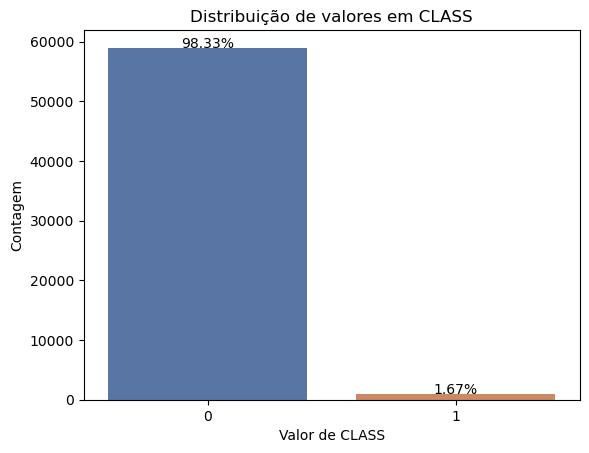

Número de positivos:  1000
Número de negativos:  59000


In [6]:
# Plotando a distribuição de valores da nossa variável resposta 'class'
class_counts = df_train['class'].value_counts()
total = class_counts.sum()

# Criando uma paleta de cores personalizada
palette = sns.color_palette("deep", len(class_counts))

# Plotando o gráfico com cores diferentes para cada barra
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)#hue=class_counts, legend=False)
plt.title('Distribuição de valores em CLASS')
plt.xlabel('Valor de CLASS')
plt.ylabel('Contagem')

# Adicionando os valores percentuais acima de cada barra
for i, count in enumerate(class_counts):
    percentage = f'{(count / total) * 100:.2f}%'
    ax.text(i, count + 0.05, percentage, ha='center')

plt.show()
plt.savefig('img/class_dist.png')
plt.close()

print('Número de positivos: ', class_counts[1])
print('Número de negativos: ', class_counts[0])

**O dataset é extremamente desbalanceado**, com a maioria dos valores de CLASS sendo negativos.

### **Substituindo os valores faltantes 'na' por Nan**

In [7]:
df_train = df_train.replace('na',np.NaN)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


### **Removendo features com apenas um único valor**
Essas features não são relevantes para o treinamento dos modelos.

In [8]:
# Primeiro converte o dataframe inteiro para formato numérico (float)
df_train = df_train.astype(float)

# Agora avalia quais colunas têm desvio-padrão zero = sem variância
for i in df_train:
  if df_train[i].std() == 0:
    df_train = df_train.drop([i],axis=1)
    print('A feature com variância zero é: ',i)

df_train.shape

A feature com variância zero é:  cd_000


(60000, 170)

Apenas uma feature tinha variância zero e foi removida.

### **Removendo duplicadas**

In [9]:
# remove colunas duplicadas
df_train = df_train.drop_duplicates(keep = 'first')

# remove linhas duplicadas (primeira transposição) e depois reformata o dataframe para o original (segunda transposição)
df_train = df_train.T.drop_duplicates().T

print(df_train.shape)

(59999, 170)


Apenas uma linha foi removida. Nenhuma coluna duplicada foi encontrada.

### **Limpeza do dataset de treino**
Faremos com ele todas as etapas feitas até aqui com o dataset de treino.

In [10]:
df_test['class'] = df_test['class'].replace(['pos','neg'],[1,0])
df_test = df_test.replace('na',np.NaN)
df_test = df_test.astype(float)
for i in df_test:
  if df_test[i].std() == 0:
    df_test = df_test.drop([i],axis=1)
    print('The feature with zero variance is : ',i)

df_test = df_test.drop_duplicates(keep = 'first')
df_test = df_test.T.drop_duplicates().T
print(df_test.shape)

/tmp/ipykernel_866/801793595.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['class'] = df_test['class'].replace(['pos','neg'],[1,0])


The feature with zero variance is :  cd_000
(16000, 170)


# **4. Exploratory Data Analysis (EDA)**

### **Verificando quantidade de valores faltantes**

In [11]:
# verifica quantidade de nulos de cada coluna exceto 'class'
valores_faltantes = dict(df_train.drop('class',axis=1).isnull().sum())
valores_faltantes = dict(sorted(valores_faltantes.items(), key=lambda item:item[1],reverse=True))

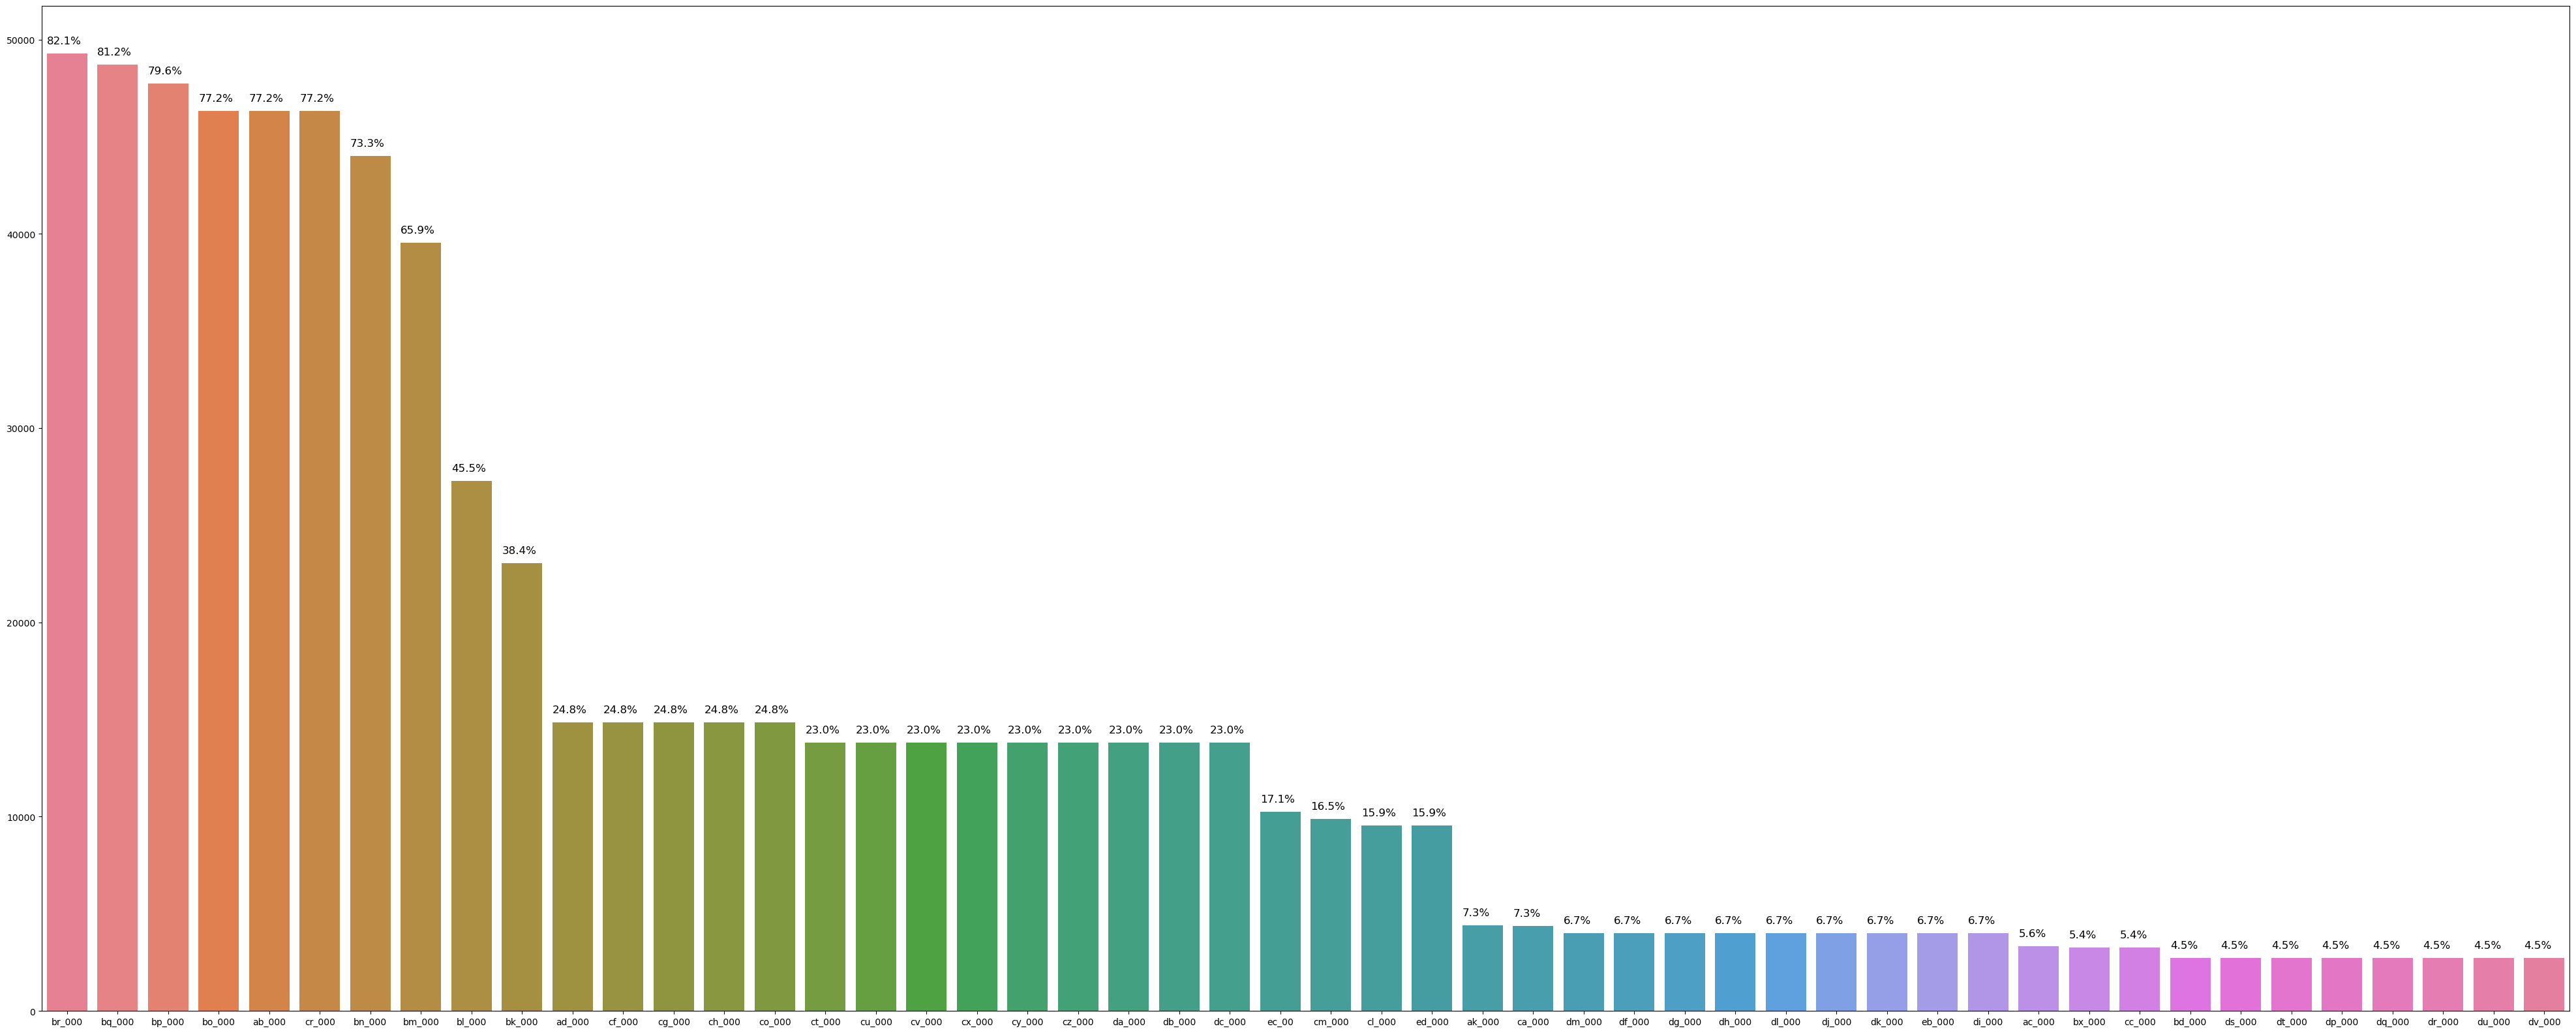

In [12]:
# plotando gráfico de barras com % de nulos nas 50 colunas com mais valores nulos
def barplot(data,sum):
  plt.figure(figsize = (50,20))
  ax = sns.barplot(x = list(data.keys())[:50], y = list(data.values())[:50], hue=list(data.keys())[:50], legend=False)

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
    x = p.get_x() 
    y = p.get_height()+500
    ax.annotate(percentage,(x,y),size=12)
  
  plt.show()
  plt.savefig('img/count_null.png')
  plt.close()

barplot(valores_faltantes,df_train.shape[0])

Conforme o gráfico acima, o dataset tem 8 features com mais de 60% de valores nulos; 16 features entre 20-60% nulos; e todas as restantes com menos de 20% nulos.

### **Separando features de histograma do dataset**
As features estão com nomes codificados. Os nomes no formato 'letras_000' são números. Os nomes no formato 'letras_00x' são intervalos (*bins*) de histogramas.

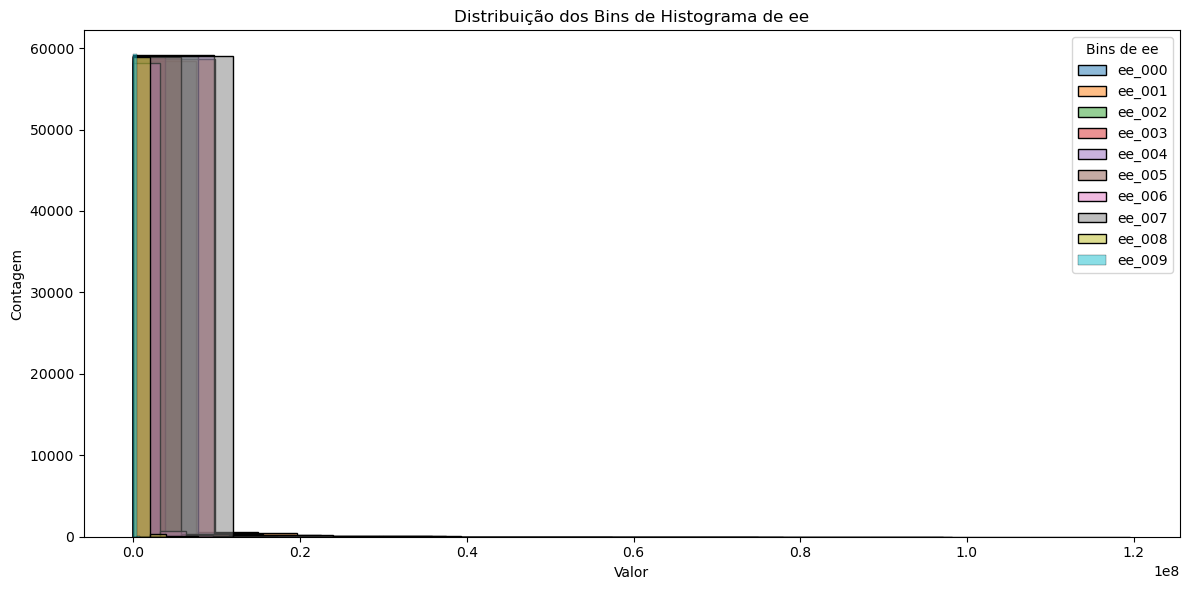

In [13]:
# Exemplo de features que representam bins de um histograma: features começadas com 'ee'

# Selecionando apenas as features que representam bins de histogramas
features_bins = ['ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009']

# Agrupando as features pelo prefixo 'ee'
df_ee = df_train[features_bins]

# Plotando histogramas para cada grupo de features
plt.figure(figsize=(12, 6))
for col in df_ee.columns:
    sns.histplot(df_ee[col], bins=10, kde=False, alpha=0.5, label=col)

plt.title('Distribuição dos Bins de Histograma de ee')
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.legend(title='Bins de ee')
plt.tight_layout()
plt.show()
plt.savefig('img/hist_feature_ee.png')
plt.close()


In [14]:
# Separando as features que são bins de histograma
hist_col = []
for i in df_train.columns:
  if i[-1] != '0': # se o último dígito do nome da coluna não é zero, então representa bin de histograma
    hist_col.append(i)

hist_col.extend(['ag_000','ay_000','az_000','ba_000','cn_000','cs_000','ee_000']) # adiciona outras features que representam bin mas que terminam em zero

hist_features = df_train[hist_col]
hist_features = hist_features.drop('class',axis=1) # exclui a variável resposta do conjunto de colunas que representam bins
num_features = df_train.drop(hist_col,axis=1) # features numéricas = dataframe sem as colunas de bins de histogramas


print(hist_features.shape)
print(num_features.shape)

(59999, 70)
(59999, 99)


Observe que existem 70 features que representam bins de histogramas e 99 features numéricas.

### **Extraindo features importantes**

- Como existem muitas features, será preciso selecionar as mais relevantes antes de realizar a EDA delas.
- Usarei o *Recursive Feature Elimination* (RFE). Ele é simples de utilizar e eficiente para selecionar features (https://machinelearningmastery.com/rfe-feature-selection-in-python/).
- Como ele funciona? De maneira resumida, ele utiliza um algoritmo de ML para rankear features e elimina aquelas com menor score. Em seguida, ele reaplica o algoritmo nas features remanescentes, repetindo o processo de eliminação até restarem apenas a quantidade de features desejadas.
- O ideal seria fazer uma seleção de algoritmos e números de features com melhor performance do RFE, mas dado o tamanho do dataset, meus recursos computacionais e o prazo disponível, vejamos como será o desempenho desta versão básica (10 top features de cada tipo - numérica ou histograma, usando algoritmo random forest). O artigo (https://machinelearningmastery.com/rfe-feature-selection-in-python/) explica como implementar essa seleção.


#### Obtendo as features mais importantes de histogramas

In [15]:
# Definindo o RFE

def top_features_rfe(X,y,n):
  estimator = RandomForestClassifier(max_depth=5) # algoritmo de ML escolhido para rankear as features
  rfe = RFE(estimator = estimator, n_features_to_select=n, verbose=0)
  rfe.fit(X,y)
  return (rfe.support_)

In [21]:
# # Obtendo as features mais importantes

hist_features['class'] = df_train['class']
# imp_hist_features = hist_features.dropna()
# y = imp_hist_features['class'] 
# X = imp_hist_features.drop('class',axis=1)
# top_hist_features_rfe = top_features_rfe(X,y,10) # procura as 10 features mais importantes
# top_hist_features=[];
# hist_col = X.columns

# for i in range(len(hist_col)):
#   if top_hist_features_rfe[i]:
#     top_hist_features.append(hist_col[i]) 

# print("As features de histograma mais importantes são: ", top_hist_features)
# print("Número de features importantes:", len(top_hist_features))

In [17]:
top_hist_features = ['ag_001',
 'ag_002',
 'ag_003',
 'ay_005',
 'ba_004',
 'cs_002',
 'ee_005',
 'ba_000',
 'cn_000',
 'ee_000']

#### Obtendo as features numéricas mais importantes:

In [29]:
num_features['class'] = df_train['class']
# imp_num_features = num_features.dropna()
# y = imp_num_features['class']
# X = imp_num_features.drop('class',axis=1)
# top_num_features_rfe = top_features_rfe(X,y,10) # seleciona as top 10 features numéricas mais importantes
# top_num_features=[];
# hist_col = X.columns
# for i in range(len(hist_col)):
#   if top_num_features_rfe[i]:
#     top_num_features.append(hist_col[i]) 

# print("Features numéricas mais importantes: ", top_num_features)
# print("Número de features numéricas mais importantes:", len(top_num_features))

In [19]:
top_num_features = ['ai_000', 'al_000', 'am_0', 'aq_000', 'bg_000', 'bh_000', 'bj_000', 'cj_000', 'df_000', 'dn_000']

Agora podemos começar a EDA. Ela será executada apenas sobre as features mais importantes que selecionamos acima.

### **EDA - Features de Histogramas**

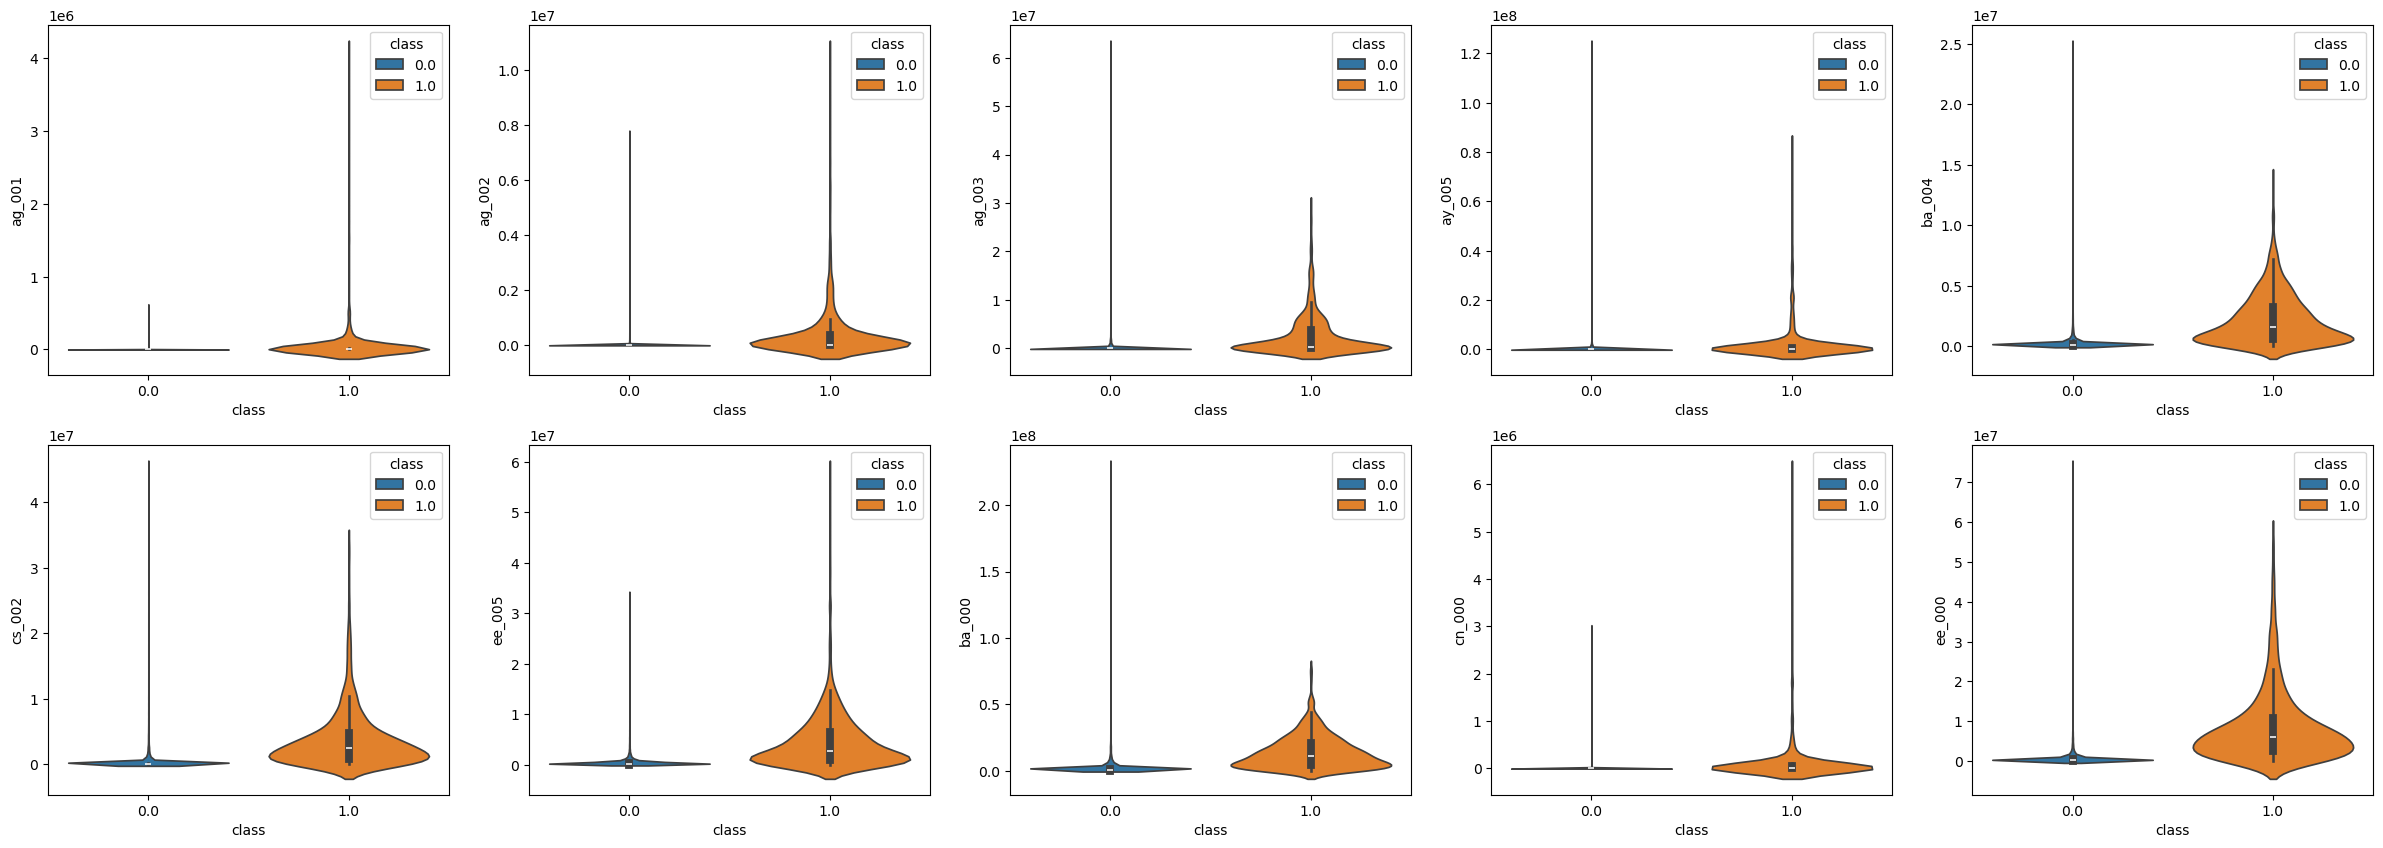

In [26]:
violin(hist_features,top_hist_features,2,5, 'violin_hist')

**Análise**:
- Quando a classe é 0, os valores das features tendem a ser bem menores (em torno de zero também).
- Quando o valor da feature aumenta, aumenta a chance da classe ser 1.
- As features ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000'] têm pouquíssimos valores quando a classe é zero (IQR quase invisível), mas têm vários valores quando a classe é 1.
- As outras features têm valores em torno de zero quando a classe é zero. Logo, se o valor dessas features estiver próximo de zero, é muito provável que a classe será 0.

Como a **dispersão** é maior quando a classe é 1 para as features ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000'], continuaremos o estudo com elas.

#### Analisando o percentil entre as melhores features e o target
A intenção é encontrar uma separação clara para quando o target é 0 ou 1.

In [24]:
# Features de interesse
f = ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000']

for feature in f:
    # Calcular os percentis 25 e 90 para cada classe
    percentile_90_class_0 = np.nanpercentile(hist_features[hist_features['class'] == 0][feature], 90)
    percentile_25_class_1 = np.nanpercentile(hist_features[hist_features['class'] == 1][feature], 25)
    
    # Calcular a diferença percentual entre os percentis
    diff_percent = ((percentile_25_class_1 - percentile_90_class_0) / percentile_25_class_1) * 100
    
    # Imprimir os resultados
    print("\nFeature ", feature)
    print("Percentil 90 (Class 0): ", percentile_90_class_0.round(2))
    print("Percentil 25 (Class 1): ", percentile_25_class_1.round(2))
    print("Diferença percentual (Class 1 vs Class 0): ", diff_percent.round(2), "%")


Feature  ba_004
Percentil 90 (Class 0):  361734.0
Percentil 25 (Class 1):  588036.5
Diferença percentual (Class 1 vs Class 0):  38.48 %

Feature  cs_002
Percentil 90 (Class 0):  256878.4
Percentil 25 (Class 1):  864141.0
Diferença percentual (Class 1 vs Class 0):  70.27 %

Feature  ee_005
Percentil 90 (Class 0):  708216.0
Percentil 25 (Class 1):  847208.0
Diferença percentual (Class 1 vs Class 0):  16.41 %

Feature  ba_000
Percentil 90 (Class 0):  2430826.4
Percentil 25 (Class 1):  4299871.0
Diferença percentual (Class 1 vs Class 0):  43.47 %

Feature  ee_000
Percentil 90 (Class 0):  1155269.6
Percentil 25 (Class 1):  2574780.0
Diferença percentual (Class 1 vs Class 0):  55.13 %


- Perceba como os valores das features são muito menores quando Class = 0. Essa **separação** de valores conforme a classe da varíavel resposta é o que nos diz que aquela feature tem bom poder classificatório.
- Como o percentil 25 para a classe 1 é maior que o percentil 90 para a classe zero, significa que **75% dos casos podem ser classificados corretamente, com 10% de margem de erro**, utilizando essas features.
- Considere a feature cs_002, por exemplo: em 75% das vezes em que Class = 1, o valor da feature é maior que 864.141.  Logo, se em um caso essa feature apresentar valor acima de 864.141, é muito provável que Class será igual a 1. Mas você precisa lembrar que, quando Class = 0, há uma chance de 10% do valor dessa feature ser maior que 256.878. Por isso, essa é a nossa margem de erro aproximada.

### **EDA - Features Numéricas**

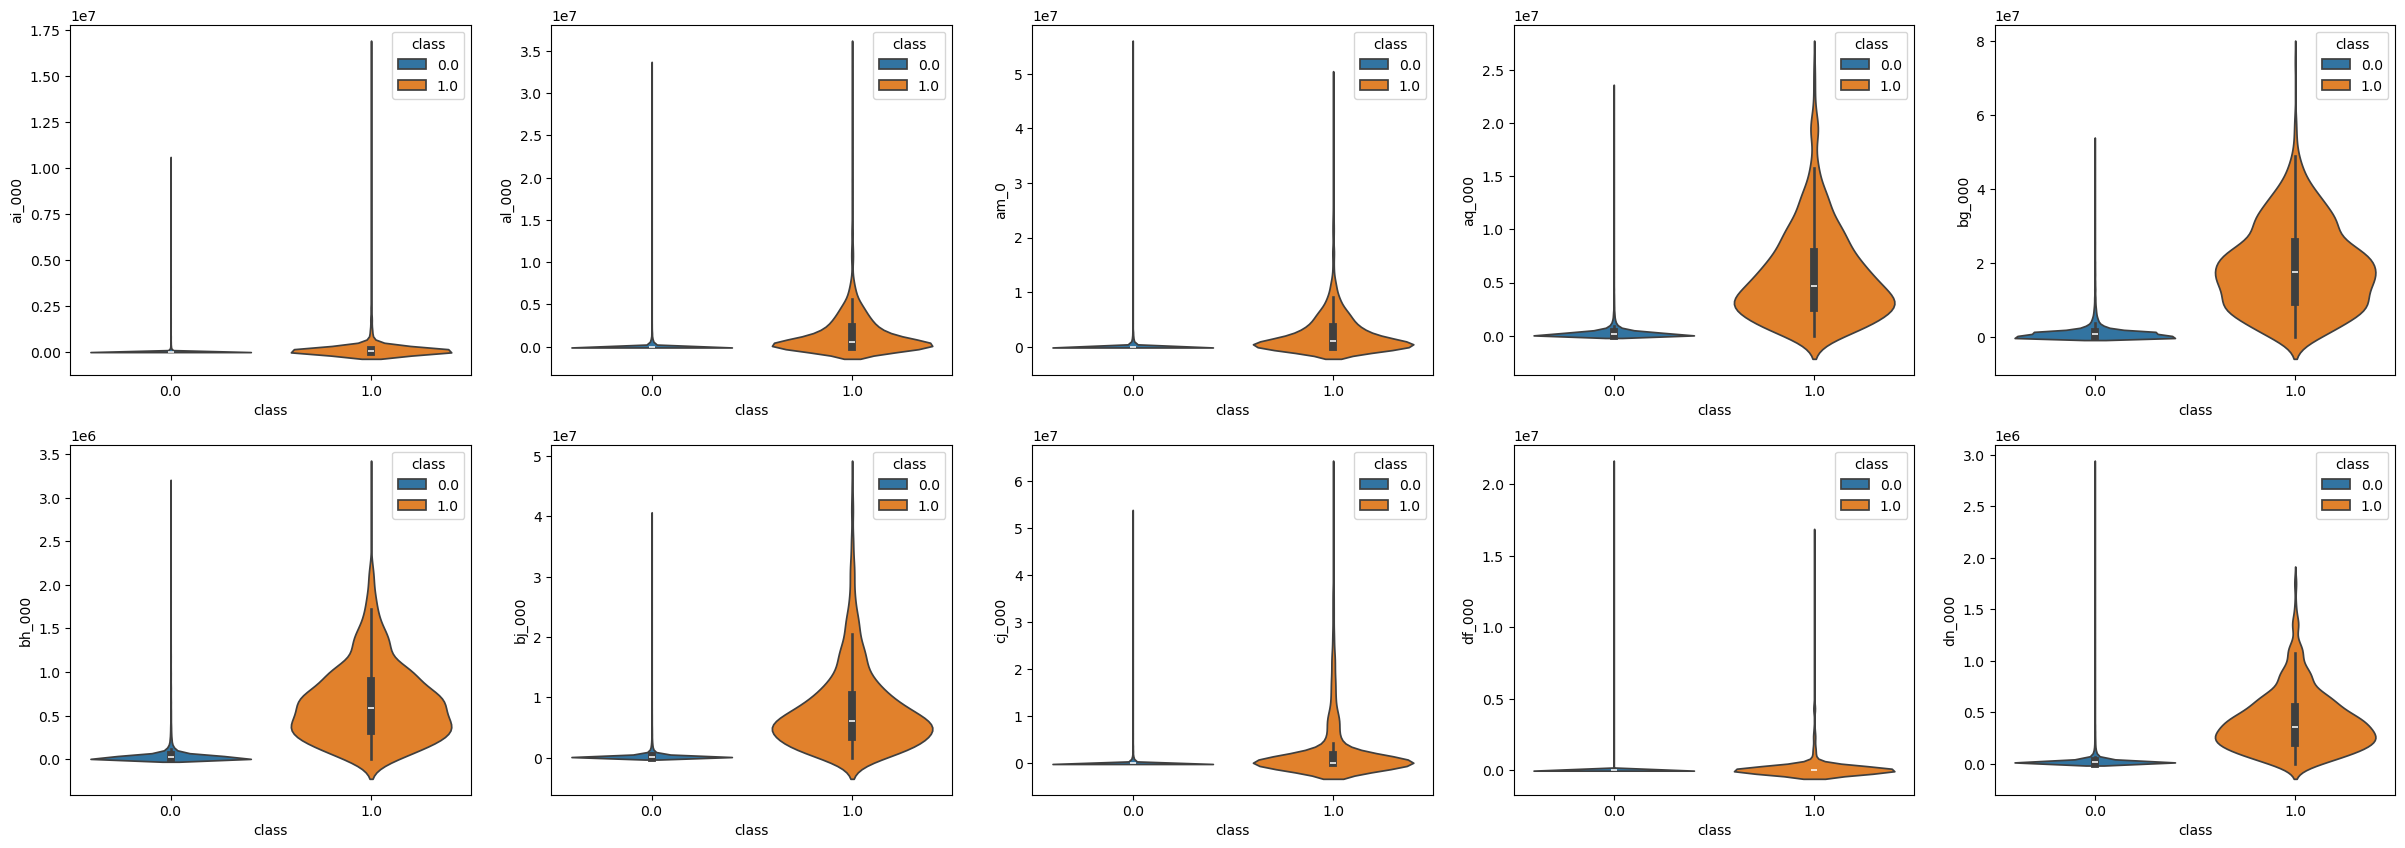

In [30]:
violin(num_features,top_num_features,2,5, 'violin_numerical')

**Análise**:
- Quando a classe é 0, os valores das features tendem a ser bem menores (em torno de zero também).
- Quando o valor da feature aumenta, aumenta a chance da classe ser 1.
- As features ['aq_000', 'bg_000', 'bh_000', 'bj_000', 'dn_000'] têm pouquíssimos valores quando a classe é zero (IQR quase invisível), mas têm vários valores quando a classe é 1.
- As outras features têm valores em torno de zero quando a classe é zero. Logo, se o valor dessas features estiver próximo de zero, é muito provável que a classe será 0.

Como a **dispersão** é maior quando a classe é 1 para as features ['aq_000', 'bg_000', 'bh_000', 'bj_000', 'dn_000'], continuaremos o estudo com elas.

#### Analisando o percentil entre as melhores features e o target
A intenção é encontrar uma separação clara para quando o target é 0 ou 1.

In [32]:
# Features de interesse
f = ['aq_000', 'bg_000', 'bh_000', 'bj_000', 'dn_000']

for feature in f:
    # Calcular os percentis 25 e 90 para cada classe
    percentile_90_class_0 = np.nanpercentile(num_features[num_features['class'] == 0][feature], 90)
    percentile_10_class_1 = np.nanpercentile(num_features[num_features['class'] == 1][feature], 10)
    
    # Calcular a diferença percentual entre os percentis
    diff_percent = ((percentile_10_class_1 - percentile_90_class_0) / percentile_10_class_1) * 100
    
    # Imprimir os resultados
    print("\nFeature ", feature)
    print("Percentil 90 (Class 0): ", percentile_90_class_0.round(2))
    print("Percentil 10 (Class 1): ", percentile_10_class_1.round(2))
    print("Diferença percentual (Class 1 vs Class 0): ", diff_percent.round(2), "%")


Feature  aq_000
Percentil 90 (Class 0):  728333.2
Percentil 10 (Class 1):  1213968.4
Diferença percentual (Class 1 vs Class 0):  40.0 %

Feature  bg_000
Percentil 90 (Class 0):  3039960.6
Percentil 10 (Class 1):  5068767.2
Diferença percentual (Class 1 vs Class 0):  40.03 %

Feature  bh_000
Percentil 90 (Class 0):  92832.0
Percentil 10 (Class 1):  161455.2
Diferença percentual (Class 1 vs Class 0):  42.5 %

Feature  bj_000
Percentil 90 (Class 0):  695903.2
Percentil 10 (Class 1):  1393952.4
Diferença percentual (Class 1 vs Class 0):  50.08 %

Feature  dn_000
Percentil 90 (Class 0):  52318.2
Percentil 10 (Class 1):  103516.4
Diferença percentual (Class 1 vs Class 0):  49.46 %


### **Resumo da EDA:**
1. Os dados são **muito** desbalanceados, com mais de 98% das ocorrências pertencendo à Class = 0.
2. A quantidade de valores faltantes é elevada: 
    - 08 features com mais de 60% dos valores faltantes;
    - 16 com 20-60% dos valores faltantes;
    - As features restantes têm menos de 20% dos valores vazios.
3. Quando *Class = 0*, a maioria das features têm valores minúsculos, próximos de zero. Logo, se o valor das features é alto, é muito provável que *Class = 1* (falha no sistema de ar).
4. Usando as melhores features de histograma ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000'], cerca de 75% das ocorrências podem ser corretamente classificadas.
5. Usando as melhores features numéricas ['aq_000', 'bg_000', 'bh_000', 'bj_000', 'dn_000'], cerca de 90% das ocorrências podem ser corretamente classificadas.

### **Lidando com valores faltantes**
- Vamos eliminar features com mais de 60% de valores faltantes.
- Vamos utilizar o método da **mediana** para preencher os valores faltantes das features com menos de 20% de faltantes.
- Vamos utilizer o método **MICE** para preencher os valores das features com 20-60% de valores faltantes.

Usaremos a mediana nas features com menos valores faltantes porque, nessa situação, a mediana não causará grandes perdas de informação no dataset, já que serão poucas ocorrências imputadas. A mediana é computacionalmente eficiente, mas pode simplificar excessivamente os dados, causando perda de informações (como a relação entre features).

Já o MICE (*Multiple Imputation by Chained Equations*) é um método de imputação amplamente utilizado. Ele é sofisticado, porque utiliza modelos de ML para estimar o valor faltante, preservando as relações e a variabilidade entre as features. É a solução ideal para features com muitos valores faltantes.

[MICE - saiba mais](https://medium.com/@kunalshrm175/multivariate-imputation-by-chained-equations-mice-2d3efb063434)

In [34]:
features_tobe_eliminated = []
median_imp_features = []
model_imp_features = []

for i in valores_faltantes.keys():
  percent = (valores_faltantes[i]/df_train.shape[0])
  if percent > 0.6:
    features_tobe_eliminated.append(i)
  elif percent < 0.2:
    median_imp_features.append(i)
  else:
    model_imp_features.append(i)

print("Features que serão removidas: ",features_tobe_eliminated)
print("Total de features a serem removidas: ",len(features_tobe_eliminated))
print("\nFeatures para MICE: ",model_imp_features)
print("Total de features para MICE: ",len(model_imp_features))
print("\nFeatures para MEDIANA: ",median_imp_features)
print("Total de features para mediana: ",len(median_imp_features))

Features que serão removidas:  ['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000']
Total de features a serem removidas:  8

Features para MICE:  ['bl_000', 'bk_000', 'ad_000', 'cf_000', 'cg_000', 'ch_000', 'co_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000']
Total de features para MICE:  16

Features para MEDIANA:  ['ec_00', 'cm_000', 'cl_000', 'ed_000', 'ak_000', 'ca_000', 'dm_000', 'df_000', 'dg_000', 'dh_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000', 'bd_000', 'ds_000', 'dt_000', 'dp_000', 'dq_000', 'dr_000', 'du_000', 'dv_000', 'bc_000', 'cp_000', 'de_000', 'do_000', 'dy_000', 'ef_000', 'ar_000', 'bz_000', 'dx_000', 'dz_000', 'ea_000', 'eg_000', 'be_000', 'dd_000', 'ce_000', 'ax_000', 'ae_000', 'af_000', 'av_000', 'bf_000', 'bs_000', 'cb_000', 'bu_000', 'bv_000', 'cq_000', 'dn_000', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008

#### **Dividir o dataset de treino e treino e cross-validation**
Necessário para a imputação de valores, especialmente quando feita por modelos (como o MICE).

In [38]:
X = df_train.drop('class',axis=1)
y = df_train['class']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) # cross validation tem 30% do total do dataset

# dados de teste são obtidos diretamente do df_test
X_test = df_test.drop('class',axis=1)
y_test = df_test['class']

X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_cv.reset_index(drop=True,inplace=True)
y_cv.reset_index(drop=True,inplace=True)
print(10*'='+" Dataset Treino "+10*'=')
print(X_train.shape)
print(y_train.shape)

print(10*'='+" Dataset Cross Validation "+10*'=')
print(X_cv.shape)
print(y_cv.shape)

print(10*'='+" Dataset de Teste "+10*'=')
print(X_test.shape)
print(y_test.shape)

========== Dataset Treino ==========
(41999, 169)
(41999,)
========== Dataset Cross Validation ==========
(18000, 169)
(18000,)
========== Dataset de Teste ==========
(16000, 169)
(16000,)


#### **Preenchendo com a mediana**
Apenas as features com menos de 20% de faltantes.

In [39]:
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train[median_imp_features])

X_train_median = median_imputer.transform(X_train[median_imp_features])
X_cv_median = median_imputer.transform(X_cv[median_imp_features])
X_test_median = median_imputer.transform(X_test[median_imp_features])

#### **Preenchendo com o MICE**
Para features com mais de 20% de faltantes.

In [41]:
# Primeiro eliminamos as features com mais de 60% faltantes
# Perceba que o MICE será treinado (vai considerar) as features com menos de 20% faltantes, preenchidas com a mediana.

X_train_mice = X_train.copy()
X_train_mice[median_imp_features] = X_train_median
X_train_mice = X_train_mice.drop(features_tobe_eliminated,axis=1)
print('Dataset de treino MICE: ', X_train_mice.shape)

X_cv_mice = X_cv.copy()
X_cv_mice[median_imp_features] = X_cv_median
X_cv_mice = X_cv_mice.drop(features_tobe_eliminated,axis=1)
print('\nDataset de CV MICE: ', X_cv_mice.shape)

X_test_mice = X_test.copy()
X_test_mice[median_imp_features] = X_test_median
X_test_mice = X_test_mice.drop(features_tobe_eliminated,axis=1)
print('\nDataset de teste MICE: ', X_test_mice.shape)

Dataset de treino MICE:  (41999, 161)

Dataset de CV MICE:  (18000, 161)

Dataset de teste MICE:  (16000, 161)


**Normalizando os dados antes de usar o MICE**
O MICE utiliza modelos de regressão linear ([detalhes](https://medium.com/full-metal-data-scientist/from-missing-to-meaningful-a-dive-into-scikit-learns-iterativeimputer-for-advanced-imputation-c175e21ffb59#:~:text=Iterative%20Imputation%3A%20For%20each%20feature,()%20and%20predict()%20method.)). Logo, para o modelo ser eficaz, é preciso garantir que os dados estejam normalizados.

In [42]:
# Função para normalizar um dataset usando o Min-Max
def normalize(df):
  x = df.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  return x_scaled, min_max_scaler

In [43]:
X_train_scaled, scaler = normalize(X_train_mice)
X_cv_scaled = scaler.transform(X_cv_mice)
X_test_scaled = scaler.transform(X_test_mice)

X_train_mice = pd.DataFrame(X_train_scaled, columns= X_train_mice.columns)
X_cv_mice = pd.DataFrame(X_cv_scaled, columns= X_cv_mice.columns)
X_test_mice = pd.DataFrame(X_test_scaled, columns= X_test_mice.columns)

/home/joaomj/miniconda3/envs/ds_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/joaomj/miniconda3/envs/ds_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


**Aplicando o MICE**

In [45]:
# Função que inicializa e aplica o MICE como imputação
def mice_imputation(df):
  mice_imputer = IterativeImputer(random_state=42)
  df_imputed = mice_imputer.fit_transform(df)
  return df_imputed, mice_imputer

In [46]:
# # CUIDADO: levou 11 minutos para executar o MICE
# X_train_imputed, mice_imputer = mice_imputation(X_train_mice)
# X_cv_imputed = mice_imputer.transform(X_cv_mice)
# X_test_imputed = mice_imputer.transform(X_test_mice)

# X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_mice.columns)
# X_cv_imputed = pd.DataFrame(X_cv_imputed, columns=X_cv_mice.columns)
# X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_mice.columns)

/home/joaomj/miniconda3/envs/ds_env/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**Guardando dataset preenchido e modelos**

Para evitar retreinar os modelos.

In [47]:
X_train_imputed['class'] = y_train
X_cv_imputed['class'] = y_cv
X_test_imputed['class'] = y_test

# Armazenando o dataframe preenchido
X_train_imputed.to_csv('data/train_mice_imputed.csv',index=False)
X_cv_imputed.to_csv('data/cv_mice_imputed.csv',index=False)
X_test_imputed.to_csv('data/test_mice_imputed.csv',index=False)

# Armazenando os imputers treinados
pickle.dump(median_imputer,open('models/median_imputer.pkl','wb'))
pickle.dump(scaler,open('models/normalizer.pkl','wb'))
pickle.dump(mice_imputer,open('models/mice_imputer.pkl','wb'))     

# **5. Feature Engineering**

Carregando o dataframe preenchido:

In [48]:
train_mice_imputed = pd.read_csv('data/train_mice_imputed.csv')
cv_mice_imputed = pd.read_csv('data/cv_mice_imputed.csv')
test_mice_imputed = pd.read_csv('data/test_mice_imputed.csv')

## **Adicionando features através do PCA**
- Vou utilizar o PCA para comprimir o dataset em N features e, depois, adicioná-las de volta ao dataset original.
- A intenção é obter novas dimensões dos dados de maneira simples, como a oferecida pelo algoritmo PCA.
- Para determinar o número N de features a serem obtidas com PCA, eu vou calcular qual é o número de features que explica 95% da variância total dos dados.

### **1. Preparar os dados**

In [52]:
# remove a variável resposta
X_train = train_mice_imputed.drop(columns=['class'])
X_cv = cv_mice_imputed.drop(columns=['class'])
X_test = test_mice_imputed.drop(columns=['class'])

### **2. Padronizando os dados**

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

### **3. Aplicando o PCA**

In [54]:
from sklearn.decomposition import PCA

# Instancie o PCA com todos os componentes
pca = PCA()

# Ajuste o PCA aos dados de treino
pca.fit(X_train_scaled)

# Determine o número de componentes necessários para explicar 95% da variância
cumsum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_var_ratio >= 0.95) + 1  # adiciona +1 porque os índices começam em 0

# Reaplique o PCA com o número de componentes selecionado
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_cv_pca = pca_final.transform(X_cv_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

In [60]:
print('O número de componentes p/explicar 95% da variância é: ', n_components)

O número de componentes p/explicar 95% da variância é:  76


### **4. Interpretando os componentes**

In [56]:
# Visualizando os componentes principais
print("Componentes Principais:")
print(pca_final.components_)

Componentes Principais:
[[ 1.26267447e-01 -7.94571951e-03 -2.08778653e-04 ...  3.26877317e-02
   1.87804926e-03  2.99408390e-03]
 [ 3.25397996e-02 -1.14753511e-02  2.25582659e-04 ... -1.02397645e-01
   1.22991534e-02  1.47720768e-02]
 [-2.95931967e-02 -2.51503306e-02  1.91627018e-03 ... -2.16984107e-02
  -1.77308624e-02 -2.68631389e-02]
 ...
 [-4.78474409e-03  3.52313121e-02 -1.69391508e-04 ... -2.90309286e-02
  -1.40618692e-03 -1.51114639e-02]
 [ 5.75509846e-03  2.35746704e-02 -4.34139395e-05 ... -4.20739328e-03
   8.21468377e-02 -8.61198701e-02]
 [ 2.97115947e-02 -3.10344156e-02  1.65876163e-04 ... -1.25127424e-02
  -2.64394439e-02 -2.31999567e-02]]


### **5. Incorporando as novas features do PCA ao dataframe original**

In [58]:
# Atualize os DataFrames originais com as novas features do PCA
train_mice_imputed_pca = pd.concat([pd.DataFrame(X_train_pca), train_mice_imputed[['class']].reset_index(drop=True)], axis=1)
cv_mice_imputed_pca = pd.concat([pd.DataFrame(X_cv_pca), cv_mice_imputed[['class']].reset_index(drop=True)], axis=1)
test_mice_imputed_pca = pd.concat([pd.DataFrame(X_test_pca), test_mice_imputed[['class']].reset_index(drop=True)], axis=1)

# Salve esses DataFrames com as novas features do PCA
train_mice_imputed_pca.to_csv('data/train_mice_imputed_pca.csv', index=False)
cv_mice_imputed_pca.to_csv('data/cv_mice_imputed_pca.csv', index=False)
test_mice_imputed_pca.to_csv('data/test_mice_imputed_pca.csv', index=False)

## **Corrigindo o balanceamento**
- Vamos utilizar o método SMOTE para aumentar a proporção de valores positivos (Class = 1) --> *oversampling*
- A classe minoritária (Class = 1) será aumentada para 50% da classe majoritária (Class = 0) --> *undersampling*
- Depois, vamos reduzir a classe majoritária (Class = 0) para ser 60% maior que a minoritária (Class = 1).
- Essa estratégia de oversampling seguida de undersampling é [recomendada pelos autores](https://arxiv.org/abs/1106.1813) do modelo para melhor performance.

O SMOTE (*Synthetic Minotiry Oversampling Technique*) é um dos métodos mais populares para fazer *oversampling* em datasets desbalanceados. Ele cria valores sintéticos da classe minoritária com base nos valores existentes. [Saiba mais](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/).


In [61]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# carregando os datasets do PCA
train_mice_imputed_pca = pd.read_csv('data/train_mice_imputed_pca.csv')
cv_mice_imputed_pca = pd.read_csv('data/cv_mice_imputed_pca.csv')
test_mice_imputed_pca = pd.read_csv('data/test_mice_imputed_pca.csv')

# dividindo em features (X) e resposta(y)
X_train_mice_imputed_pca = train_mice_imputed_pca.drop('class', axis=1)
y_train_mice_imputed_pca = train_mice_imputed_pca['class']


X_cv_mice_imputed_pca = cv_mice_imputed_pca.drop('class', axis=1)
y_cv_mice_imputed_pca = cv_mice_imputed_pca['class']

X_test_mice_imputed_pca = test_mice_imputed_pca.drop('class', axis=1)
y_test_mice_imputed_pca = test_mice_imputed_pca['class']


# preparando o pipeline para o modelo
over = SMOTE(sampling_strategy=0.5,random_state=42) # oversampling a classe positiva em 50%
under = RandomUnderSampler(sampling_strategy=0.6) # undersampling a classe negativa em 60%
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transformando o dataset
X_train_mice_imputed_pca, y_train_mice_imputed_pca = pipeline.fit_resample(X_train_mice_imputed_pca, y_train_mice_imputed_pca)

In [62]:
pd.DataFrame(y_train_mice_imputed_pca).value_counts()

class
0.0      34415
1.0      20649
Name: count, dtype: int64

In [63]:
print('Dataset depois do balanceamento com SMOTE ')
print('='*20+'Dados de treino'+'='*20)
print(X_train_mice_imputed_pca.shape)
print(y_train_mice_imputed_pca.shape)
print('='*20+'Dados de CV'+'='*20)
print(X_cv_mice_imputed_pca.shape)
print(y_cv_mice_imputed_pca.shape)
print('='*20+'Dados de teste'+'='*20)
print(X_test_mice_imputed_pca.shape)
print(y_test_mice_imputed_pca.shape)

Dataset depois do balanceamento com SMOTE 
====================Dados de treino====================
(55064, 76)
(55064,)
====================Dados de CV====================
(18000, 76)
(18000,)
====================Dados de teste====================
(16000, 76)
(16000,)


#### **Salvando os datasets**

In [64]:
pickle.dump((X_train_mice_imputed_pca,y_train_mice_imputed_pca),open('data/mice_train_data.pkl','wb'))
pickle.dump((X_cv_mice_imputed_pca,y_cv_mice_imputed_pca),open('data/mice_cv_data.pkl','wb'))
pickle.dump((X_test_mice_imputed_pca,y_test_mice_imputed_pca),open('data/mice_test_data.pkl','wb'))

# **6. Modelling**

Carregando os dados

In [66]:
# Carrega os datasets que passaram pelo MICE e PCA
X_train, y_train = pickle.load(open('data/mice_train_data.pkl', 'rb'))
X_cv,y_cv = pickle.load(open('data/mice_cv_data.pkl', 'rb'))
X_test, y_test = pickle.load(open('data/mice_test_data.pkl', 'rb'))

In [67]:
print('='*20+'Dados de Treino'+'='*20)
print(X_train.shape)
print(y_train.shape)
print('='*20+'Dados CV'+'='*20)
print(X_cv.shape)
print(y_cv.shape)
print('='*20+'Dados de Teste'+'='*20)
print(X_test.shape)
print(y_test.shape)

====================Dados de Treino====================
(55064, 76)
(55064,)
====================Dados CV====================
(18000, 76)
(18000,)
====================Dados de Teste====================
(16000, 76)
(16000,)


## **Método de Modelagem**:

1. Vamos criar um modelo aleatório (*dumb model*) que classificará todas as ocorrências como pertencentes à classe majoritária (negativa). Usando esse modelo, obteremos o pior valor para nossa métrica, que é o **F1-Macro Score**. Com esse score, podemos avaliar o desempenho dos outros modelos de ML.

2. Vamos treinar o conjunto de dados em modelos convencionais como Regressão Logística, *Decision Trees*, *Random Forest* e XGBoost.

3. Realizaremos ajuste de hiperparâmetros em todos esses modelos usando GridSearchCV e RandomizedSearchCV. Em seguida, iremos re-treinar os modelos com os melhores valores de parâmetros obtidos do ajuste de hiperparâmetros. Em seguida, calcularemos o F1-Macro nos dados de Treino, CV (validação cruzada) e Teste para todos esses modelos.

4. Em nosso problema, o custo de falsos negativos (FN) é maior do que o custo de falsos positivos (FP). **Isso significa que mais importância deve ser dada ao recall em comparação com a precisão** (porque o recall diz o quão bom o modelo é em identificar todas as ocorrências positivas, enquanto a precisão avalia o quão bom o modelo é em evitar falsos positivos)  Portanto, teremos que ajustar o threshold de probabilidade (valor padrão = 0,5).

5. A métrica de custo mencionada no problema é: Custo = (10 x FP) + (500 x FN).

6. O threshold de probabilidade correto será aquele que resultar no custo mínimo.

7. Usaremos a **precision recall curve** do sklearn para obter os valores do threshold de probabilidade. Ela calcula pares de precisão-recall para diferentes thresholds. Usando esses thresholds, calcularemos o custo e selecionaremos threshold que resultar no menor custo. Utilizaremos os dados de Validação Cruzada para determinar esse valor de limiar de probabilidade.

8. Com esse threshold de probabilidade, vamos prever a classe para os Dados de Treino, CV e Teste e calcularemos o custo de Treino, CV e Teste para todos os modelos. O modelo que resultar no **menor Custo de Teste** será considerado o melhor modelo.

In [ ]:
# Cria um dataframe para armazenar os resultados dos testes
results_df = pd.DataFrame(columns=['modelo', 'probability_threshold', 'custo_teste'])

## **Modelo Baseline**

In [143]:
# Primeiro é preciso converter os targets para inteiro, senão a confusion_matrix retorna erro
# https://www.kaggle.com/discussions/general/107836

y_test = y_test.astype(int)

Macro average f1-score :  0.4941
Custo Teste: $ 187500


/tmp/ipykernel_866/1727808474.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


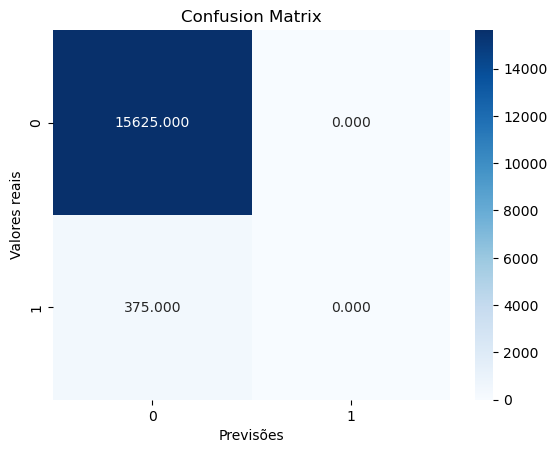

In [164]:
n = y_test.shape[0]
y_test_pred = np.zeros(n)
y_test_pred = y_test_pred.astype(int)
cm = confusion_matrix(y_test,y_test_pred)
labels=[0,1]
sns.heatmap(cm, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);

# textos
plt.xlabel('Previsões');
plt.ylabel('Valores reais'); 
plt.title('Confusion Matrix');
  
f1_scr = f1_score(y_test,y_test_pred, average = 'macro')
print("Macro average f1-score : ", f1_scr.round(4))
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Teste: $", cost)

# grava resultados
results_df = save_results(results_df, 'dumb', 0.0, cost)

## **Regressão Logística**

In [108]:
# a variável resposta deve ser INT, senão o classificador retorna erro
y_train = y_train.astype(int)

{'alpha': 0.001}


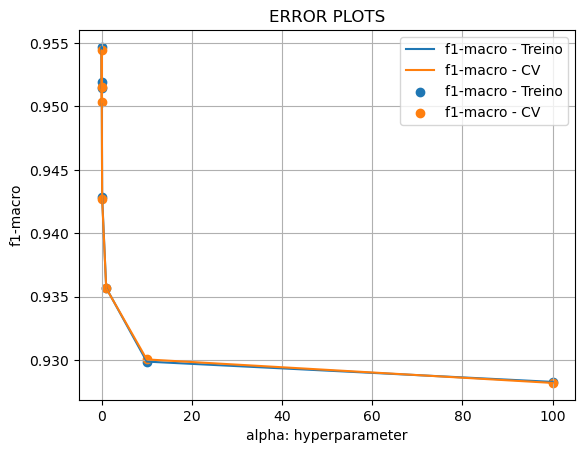

In [107]:
alpha = [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]
param = {'alpha' : alpha}

# criando o classificador SGD
clf = SGDClassifier(loss='log_loss', n_jobs=-1, random_state = 42, class_weight='balanced')

# configurando o gridsearch
tuning = GridSearchCV(estimator=clf,param_grid=param,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
tuning.fit(X_train,y_train)

# obtendo os melhores parâmetros e exibindo
best = tuning.best_params_
print(best)

# plotando o gráfico de cv
cv_plot(tuning.cv_results_,alpha)

### **Encontrando a melhor Regressão Logística**

In [112]:
# O último target que não foi convertido para INT
y_cv = y_cv.astype(int)

In [114]:
# Calibra o SGD Classifier nos dados de treino
best_LR_model = SGDClassifier(alpha=0.001,loss='log_loss' , n_jobs = -1, random_state=42, class_weight= 'balanced')
calib_LR = CalibratedClassifierCV(best_LR_model, cv=10, method='sigmoid')
calib_LR.fit(X_train,y_train)

# Realiza previsões nos dados de treino, cv e teste com o classificador calibrado
y_pred = calib_LR.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro f1-score médio nos dados de treino: ", f1_scr.round(4))

y_pred = calib_LR.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro f1-score médio nos dados de CV: ", f1_scr.round(4))

y_pred = calib_LR.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro f1-score médio nos dados de teste: ", f1_scr.round(4))

Macro f1-score médio nos dados de treino:  0.9508
Macro f1-score médio nos dados de CV:  0.7845
Macro f1-score médio nos dados de teste:  0.8238


### **Encontrando a melhor threshold de probabilidade**
Lembre-se que a intenção é encontrar aquela que resulta no menor custo. A threshold padrão é 0.5.

In [165]:
# previsões do classificador calibrado
y_train_pred = calib_LR.predict_proba(X_train)[:,1] 
y_cv_pred = calib_LR.predict_proba(X_cv)[:,1]
y_test_pred = calib_LR.predict_proba(X_test)[:,1]

# descobre a melhor threshold de acordo com precision e recall das previsões feitas nos dados cv
precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)
print("Melhor Threshold é : ", p.round(4))

# compara as previsões com os dados de treino
y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Treino: $", cost)

# compara as previsões com os dados de cv
y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo CV: $", cost)

# compara as previsões com os dados de teste
y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Teste: $", cost)

Melhor Threshold é :  0.3142
Custo Treino: $ 658730
Custo CV: $ 14240
Custo Teste: $ 17370


In [166]:
# gravando os resultados
results_df = save_results(results_df, 'lr_model', p, cost)
results_df

,modelo,probability_threshold,custo_teste
0,dumb,0.000000,187500
1,lr_model,0.314198,17370


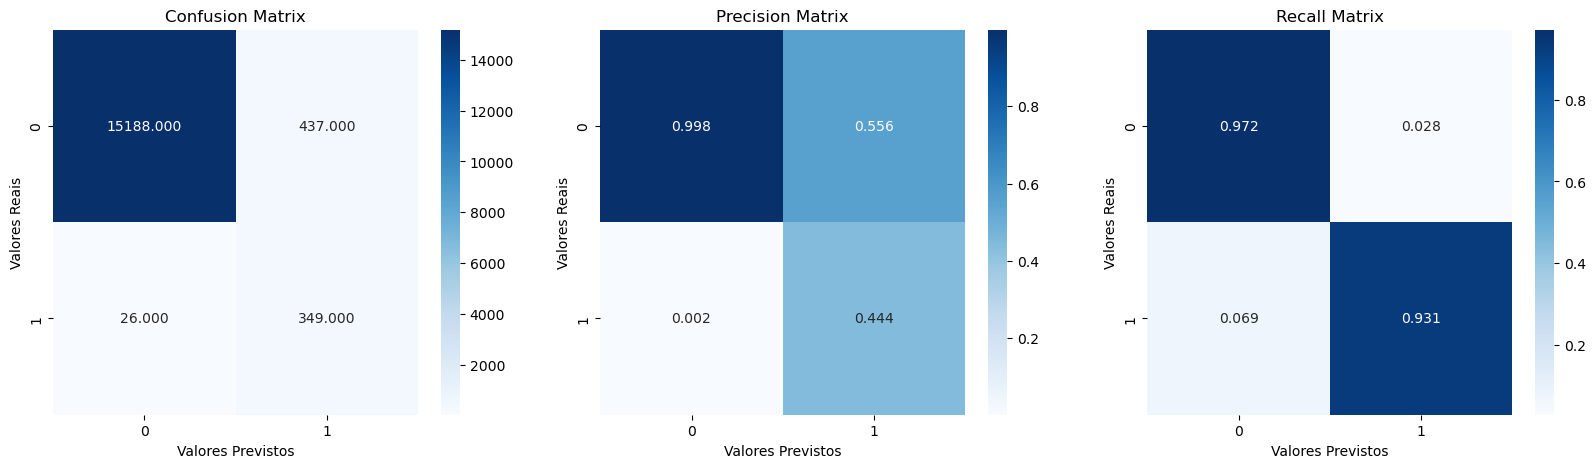

In [167]:
# constroi o heatmap de confusion matrix para as previsões sobre os dados de teste
cm_heatmap(cm)

## **Decision Trees**

In [ ]:
max_depth = [2, 5, 10, 30, 50]
min_samples_split = [2, 5, 10, 50, 100]
param = {'max_depth':max_depth,'min_samples_split':min_samples_split}
clf = DecisionTreeClassifier(class_weight = 'balanced' , random_state=42)
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=0)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

### **Encontrando a melhor Decision Tree**

In [171]:
best_DT_model = DecisionTreeClassifier(max_depth = 30, min_samples_split = 10, class_weight = 'balanced' , random_state=42)

calib_DT = CalibratedClassifierCV(best_DT_model, cv=3, method='sigmoid')
calib_DT.fit(X_train,y_train)

y_pred = calib_DT.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de treino: ", f1_scr.round(4))

y_pred = calib_DT.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de CV: ", f1_scr.round(4))

y_pred = calib_DT.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de teste: ", f1_scr.round(4))

Macro F1-Score médio para dados de treino:  0.9972
Macro F1-Score médio para dados de CV:  0.7778
Macro F1-Score médio para dados de teste:  0.809


### **Encontrando a melhor threshold**

In [172]:
y_train_pred = calib_DT.predict_proba(X_train)[:,1] 
y_cv_pred = calib_DT.predict_proba(X_cv)[:,1]
y_test_pred = calib_DT.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("A melhor threshold é: ", p.round(4))

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Treino: ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo CV: ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Teste: ", cost)

A melhor threshold é:  0.2829
Custo Treino:  10490
Custo CV:  24450
Custo Teste:  23220


In [173]:
# gravando os resultados
results_df = save_results(results_df, 'dt_model', p, cost)
results_df

,modelo,probability_threshold,custo_teste
0,lr_model,0.314198,17370
1,dumb,0.000000,187500
2,dt_model,0.282907,23220


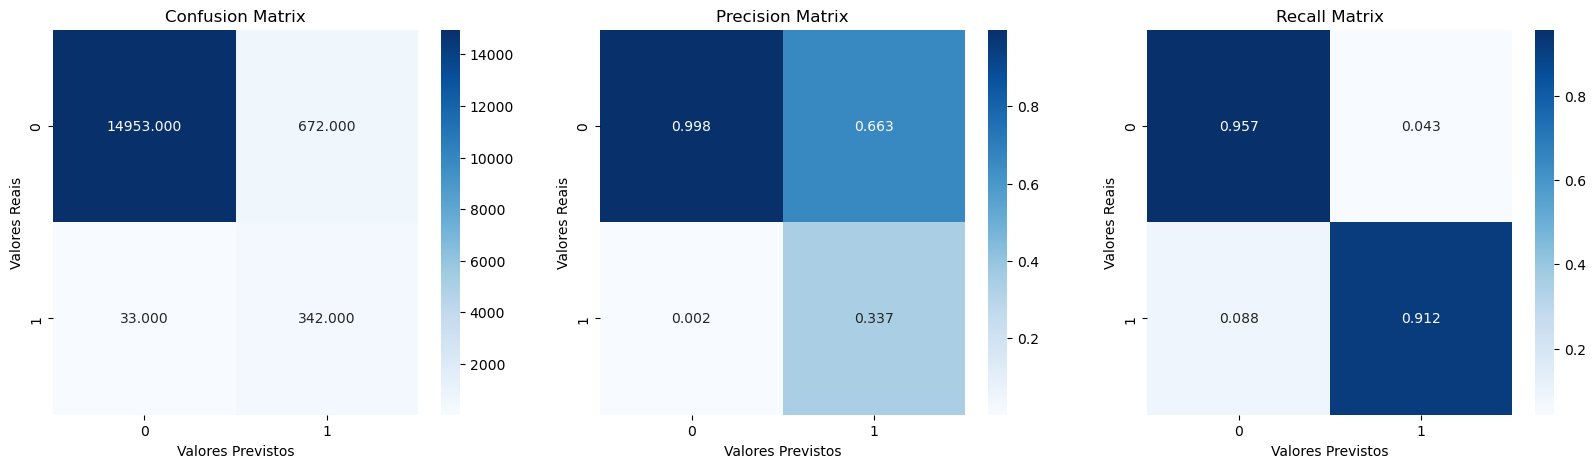

In [174]:
# heatmap da DT
cm_heatmap(cm)

## **Random Forest**

In [175]:
max_depth = [5, 10,20, 50]
n_estimators = [10,25,50,80,100]
min_samples_split = [2,5,10,50]
param = {'max_depth':max_depth,'n_estimators':n_estimators,'min_samples_split':min_samples_split}
clf = RandomForestClassifier(class_weight = 'balanced' , random_state=42)
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=0)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

{'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 20}


### **Encontrando a melhor Random Forest**

In [178]:
best_RF_model = RandomForestClassifier(max_depth = 50, n_estimators =80 ,min_samples_split=2,n_jobs=-1,class_weight = 'balanced' , random_state=42, criterion='gini')
calib_RF = CalibratedClassifierCV(best_RF_model, cv=3, method='sigmoid')
calib_RF.fit(X_train,y_train)

y_pred = calib_RF.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de treino: ", f1_scr.round(4))

y_pred = calib_RF.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de CV: ", f1_scr.round(4))

y_pred = calib_RF.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro F1-Score médio para dados de teste: ", f1_scr.round(4))

Macro F1-Score médio para dados de treino:  0.9998
Macro F1-Score médio para dados de CV:  0.8463
Macro F1-Score médio para dados de teste:  0.867


### **Encontrando a melhor threshold**

In [179]:
y_train_pred = calib_RF.predict_proba(X_train)[:,1]
y_cv_pred = calib_RF.predict_proba(X_cv)[:,1]
y_test_pred = calib_RF.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)
print("A melhor threshold é: ", p.round(4))

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo treino: ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo CV: ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Custo Teste: ", cost)

A melhor threshold é:  0.0169
Custo treino:  10160
Custo CV:  11750
Custo Teste:  11670


In [180]:
# gravando os resultados
results_df = save_results(results_df, 'rf_model', p, cost)
results_df

,modelo,probability_threshold,custo_teste
0,lr_model,0.314198,17370
1,dumb,0.000000,187500
2,dt_model,0.282907,23220
3,rf_model,0.016898,11670


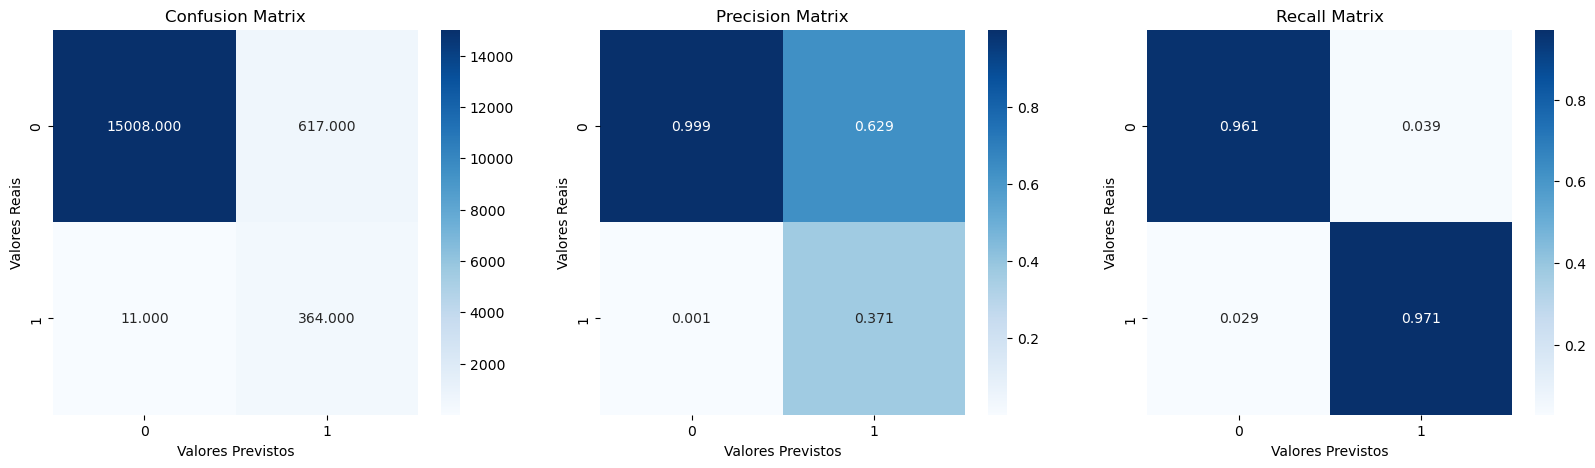

In [181]:
# heatmap da RF
cm_heatmap(cm)

## **XGBoost**

## **Resumo dos Modelos**

In [168]:
# Ordena results_df pela coluna 'custo_teste' em ordem crescente
results_df = results_df.sort_values(by='custo_teste')

# Mostra o DataFrame ordenado
results_df

,modelo,probability_threshold,custo_teste
1,lr_model,0.314198,17370
0,dumb,0.000000,187500


# 7. Communication